# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [166]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv
from panel.interact import interact
from panel import widgets

pn.extension()

%matplotlib inline

In [167]:
# Read the Mapbox API key
load_dotenv()
mapbox_token = os.getenv("MAPBOX_API_KEY")

# Import Data

In [168]:
# Import the CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

file_path_2 = Path("Data/neighborhoods_coordinates.csv")
df_neighborhood_locations = pd.read_csv(file_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

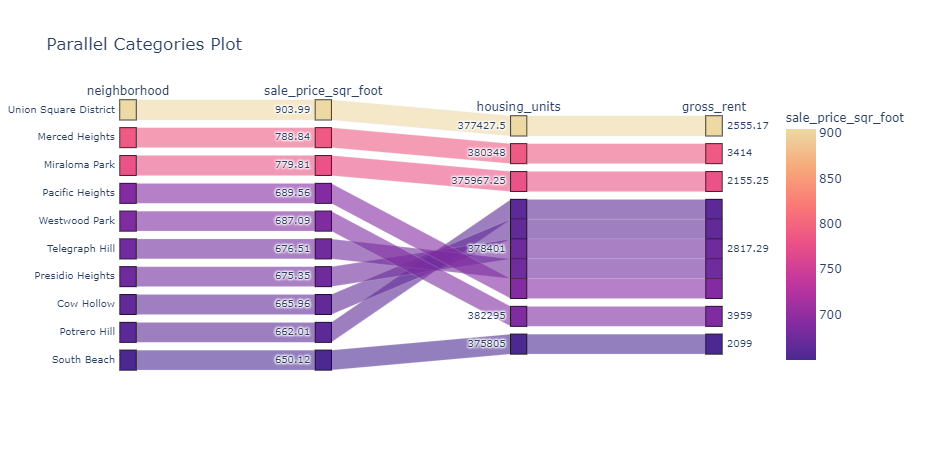

In [177]:
# Define Panel Visualization Functions
housing_unit_by_year = sfo_data.groupby(["year"])
def housing_units_per_year():
    """Housing Units Per Year."""
#    gross_house_year = sfo_data['housing_units'].groupby(by = 'year', level=None).mean()
#    fig_avg_house_year = plt.figure()
#    fig_housing_units = px.bar (gross_house_year,
#        title= 'Average Gross Rent in San Francisco')
    #fig_housing_units.set_xlabel("Year")
    #fig_housing_units.set_ylabel("Gross Rent")
        
#    return fig_housing_units

    mean_housing_units = sfo_data.groupby(["year"])["housing_units"].mean()
    sfo_grouped_min = sfo_data.groupby(["year"])["housing_units"].min().min()
    sfo_grouped_max = sfo_data.groupby(["year"])["housing_units"].max().max()
    sfo_grouped_std = sfo_data["housing_units"].std()
    #TODO fix years...
    first_year = mean_housing_units.index[0]
    last_year = mean_housing_units.index[-1]
    fig_housing_units = mean_housing_units.plot.bar(
        xlim=[first_year, last_year],
        ylim=[sfo_grouped_min - sfo_grouped_std, sfo_grouped_max + sfo_grouped_std]
    )
    fig_housing_units.set_title("Housing Units in San Francisco from 2010 to 2016")
    fig_housing_units.set_xlabel("Year")
    fig_housing_units.set_ylabel("Nbr. Housing Units")
    plt.show()
    #plt.close(fig_housing_units)
    return fig_housing_units

    # YOUR CODE HERE!
    #gross_house_year = sfo_data['housing_units'].groupby(by = 'year', level=None).mean()
    #boundry = housing_unit.std()
    #avg_house_per_year_plt = plt.figure()
    #avg_gross_year_rent_plot = gross_rent_year.plot.bar(
       # title='Average Gross Rent in San Francisco')
   # avg_gross_year_rent_plot.set.xlabel("Year")
   # avg_gross_year_rent_plot.set.ylabel("Gross Rent")
    #return avg_house_per_year_plt
def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    mean_gross_rent = sfo_data.groupby(["year"])["gross_rent"].mean()
    # YOUR CODE HERE!
    return px.line(mean_gross_rent,
       title='Average Gross Rent in San Francisco',
       labels={"year": "Year", "value": "Gross Rent"}
       #xlim=(housing_unit_by_year.first().index.min(), housing_unit_by_year.first().index.max())
    )


def average_sales_price():
    """Average Sales Price Per Year."""
    
    return px.line(sfo_data.groupby(["year"])['sale_price_sqr_foot'].mean(),
        title='Average Sales Price in San Francisco',
        labels={"year":'Year', "value":'Avg. Sale Price'},
        #xlim=(housing_unit_by_year.first().index.min(), housing_unit_by_year.first().index.max())
    )

neighborhood_df = sfo_data.groupby(['year','neighborhood']).mean().reset_index()


def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    
    sfo_data2 = pd.read_csv("Data/sfo_neighborhoods_census_data.csv")
    avg_price_df = sfo_data2.groupby(by=['year', 'neighborhood'])
    avg_price_mean = avg_price_df.mean()

    sfo_grouped_year_and_nbhd_plot = avg_price_mean.hvplot.line(
        x='year',
        y='sale_price_sqr_foot',
        ##labels={"year":'Year', "value":'Avg. Sale Price'} a revoir avec MILAD
        xlabel= 'Year',
        ylabel='Price per Sq Foot',
        groupby='neighborhood',
        width=600
    ).opts(yformatter='%0f')

    return sfo_grouped_year_and_nbhd_plot





def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
    groupby_neighborhood = sfo_data.groupby(["neighborhood"]).mean()
    top_10_most_expensive = groupby_neighborhood.sort_values(by='sale_price_sqr_foot', ascending=False).head(10)
    top_10_most_expensive = top_10_most_expensive.reset_index()
    top_10_most_expensive
    
    return px.bar(top_expensive_neighborhood['sale_price_sqr_foot'],
        title='Top 10 Expensive Neighborhoods in SFO',
        labels={"neighborhood":'Neighborhood', "value":'Avg. Sales Price per Square Foot'}
        #xlabel='Neighborhood',
        #shared_axes=False,
        #ylabel='Avg. Sales Price per Square Foot', 
        #rot=45
    )

#def parallel_coordinates():
#    """Parallel Coordinates Plot."""
    
    # YOUR CODE HERE!
#    return px.parallel_coordinates(
#        top_expensive_neighborhood, 
#        title='Parallel Coordinates Plot',
#        color='sale_price_sqr_foot'
#    )

def parallel_coordinates():
    """Parallel Coordinates Plot."""
    groupby_neighborhood = sfo_data.groupby(["neighborhood"]).mean()
    top_10_most_expensive = groupby_neighborhood.sort_values(by="sale_price_sqr_foot", ascending=False).head(10)
    top_10_most_expensive = top_10_most_expensive.reset_index()
    top_10_most_expensive_parallel = px.parallel_coordinates(top_10_most_expensive, color='sale_price_sqr_foot')
    return top_10_most_expensive_parallel


def parallel_categories():
    """Parallel Categories Plot."""
    
    # YOUR CODE HERE!
    return px.parallel_categories(
        top_expensive_neighborhood.reset_index(), 
        color='sale_price_sqr_foot',
        title='Parallel Categories Plot',
        color_continuous_scale=px.colors.sequential.Agsunset
        )
    
    

def neighborhood_map():
    """Neighborhood Map"""
    
    # YOUR CODE HERE!

    new_avg_values_neighborhood=avg_values_neighborhood.reset_index().rename(columns = {'neighborhood':'Neighborhood'})
    neighborhood_location=pd.merge(df_neighborhood_locations,new_avg_values_neighborhood, on='Neighborhood')
    
    return px.scatter_mapbox(neighborhood_location,
                            lat="Lat",
                            lon="Lon",
                            size='sale_price_sqr_foot',
                            color='gross_rent',
                            hover_name='Neighborhood',
                            zoom=11,
                            color_continuous_scale=px.colors.sequential.Jet
                            )
parallel_categories()    


#housing_units_per_year()
#average_gross_rent()
#average_sales_price()
#average_price_by_neighborhood()
##plot_avg_price_per_sq_ft() 
#top_most_expensive_neighborhoods() 
#parallel_coordinates()
#parallel_categories()
#neighborhood_map()


## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [ ]:
row1 = pn.Row("# Row 1", housing_units_per_year(), average_gross_rent(), average_sales_price())
row2 = pn.Row("# Row 2", parallel_categories(), parallel_coordinates())
row3 = pn.Row("# Row 3", average_price_by_neighborhood(), top_most_expensive_neighborhoods())
row4 = pn.Row("# Row 4", neighborhood_map())


In [171]:
location_column = pn.Column(' Visual analysis of the real estate investment opportunities in San Fransco with interactive map with the average prices per neighborhood',
                          neighborhood_map())

yearly_market_analysis = pn.Row(housing_units_per_year(), average_gross_rent(), average_sales_price())

neighborhood_analysis = pn.Column(average_price_by_neighborhood(), top_most_expensive_neighborhoods())

parallel_plot_analysis = pn.Column(parallel_coordinates(), parallel_categories())


panel_content = pn.Tabs(
    ('Welcome', location_column),
    ('Yearly Market Analysis', yearly_market_analysis),
    ('Neighborhood Analysis', neighborhood_analysis),
    ('Parallel Plot Analysis', parallel_plot_analysis)
)

panel = pn.Column(f'# Real Estate Analysis of San Francisco from {sfo_data.index.min()} to {sfo_data.index.max()}<br/>',
                  panel_content
                 )

KeyError: 'Neighborhood'

## Serve the Panel Dashboard

In [ ]:
panel.servable()